# Mixture Density Networks

Mixture density networks (MDN) (Bishop, 1994) are a class
of models obtained by combining a conventional neural network with a
mixture density model.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import inferpy as inf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
    """Plots the mixture of Normal models to axis=ax comp=True plots all
    components of mixture model
    """
    x = np.linspace(-10.5, 10.5, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Normal ' + str(i))
    ax.plot(x, final, label='Mixture of Normals ' + label)
    ax.legend(fontsize=13)


def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """Draws samples from mixture model.

    Returns 2 d array with input X and sample from prediction of mixture model.
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(
                    zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
    return samples

## Data

We use the same toy data from
[David Ha's blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/), where he explains MDNs. It is an inverse problem where
for every input $x_n$ there are multiple outputs $y_n$.

Size of features in training data: (5000, 1)
Size of output in training data: (5000,)


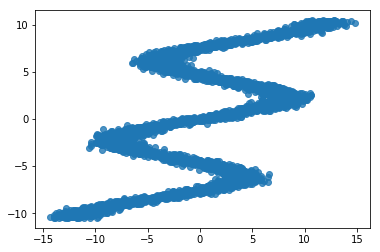

In [3]:
def build_toy_dataset(N):
    y_data = np.random.uniform(-10.5, 10.5, N).astype(np.float32)
    r_data = np.random.normal(size=N).astype(np.float32)    # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((N, 1))
    return x_data, y_data

import random 

tf.random.set_random_seed(42)
np.random.seed(42)
random.seed(42)

#inf.setseed(42)

N = 5000    # number of data points
D = 1    # number of features
K = 20    # number of mixture components

X_train, y_train = build_toy_dataset(N)


print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
sns.regplot(X_train, y_train, fit_reg=False)
plt.show()

## Fitting a Neural Network

We could try to fit a neural network over this data set. However, in this data set for each x value there are multiple y values. So, things do not work as should be using standard neural networks.

Let's define first the neural network. We use `tf.layers` to construct neural networks. We specify a three-layer network with 15 hidden units for each hidden layer.

In [4]:
def neural_network(X):
    # 2 hidden layers with 15 hidden units
    net = tf.layers.dense(X, 15, activation=tf.nn.relu)
    net = tf.layers.dense(net, 15, activation=tf.nn.relu)
    out = tf.layers.dense(net, 1, activation=None)
    return out

Let's now try to fit the neural network to the data

W0919 11:50:01.637763 4464960960 deprecation.py:323] From <ipython-input-4-afa83d17ad8c>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0919 11:50:01.655109 4464960960 deprecation.py:506] From /Users/rcabanas/venv/InferPy/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0919 11:50:02.135162 4464960960 deprecation.py:323] From /Users/rcabanas/venv/InferPy/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` 

511227740.0
462885000.0
462411170.0
462349630.0
462345150.0
462343040.0
462340160.0
462339230.0
462338560.0
462338370.0


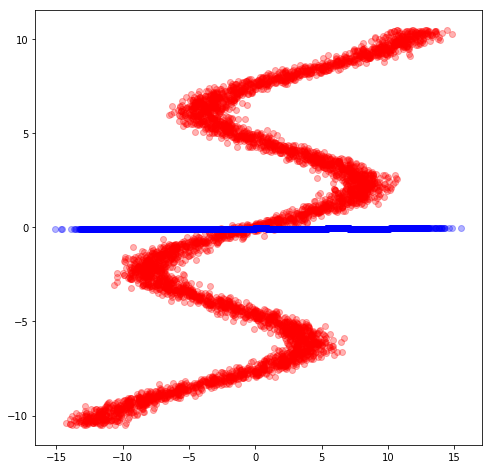

In [5]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None])

y_out = neural_network(x)

lossfunc = tf.nn.l2_loss(y_out-y);

train_op = tf.train.AdamOptimizer(learning_rate=0.1).minimize(lossfunc)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

NEPOCH = 100
for i in range(NEPOCH):
    sess.run(train_op,feed_dict={x: X_train, y: y_train})
    if i%10==0:
                print(sess.run(lossfunc,feed_dict={x: X_train, y: y_train}))    

X_test, _ = build_toy_dataset(N)          
y_test = sess.run(y_out,feed_dict={x: X_test})

plt.figure(figsize=(8, 8))
plt.plot(X_train,y_train,'ro',X_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

As can be seen, the neural network is not able to fit this data set

## Mixture Density Network (MDN)

We use a MDN with a mixture of 20 normal distributions parameterized by a
feedforward network. That is, the membership probabilities and
per-component mean and standard deviation are given by the output of a
feedforward network.


We define our probabilistic model using `Inferpy` constructs. Specifically, we use the `MixtureGaussian` distribution, where the the parameters of this network are provided by our feedforwrad network.

In [6]:
def neural_network(X):
    """loc, scale, logits = NN(x; theta)"""
    # 2 hidden layers with 15 hidden units
    net = tf.layers.dense(X, 15, activation=tf.nn.relu)
    net = tf.layers.dense(net, 15, activation=tf.nn.relu)
    locs = tf.layers.dense(net, K, activation=None)
    scales = tf.layers.dense(net, K, activation=tf.exp)
    logits = tf.layers.dense(net, K, activation=None)
    return locs, scales, logits


@inf.probmodel
def mdn():
    with inf.datamodel():
        x = inf.Normal(loc = tf.ones([D]), scale = 1.0, name="x")
        locs, scales, logits = neural_network(x)
        y = inf.MixtureGaussian(locs, scales, logits=logits, name="y")
    
m = mdn()


W0919 11:50:07.330360 4464960960 deprecation_wrapper.py:119] From /Users/rcabanas/GoogleDrive/UAL/inferpy/repo/InferPy/inferpy/models/prob_model.py:63: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0919 11:50:07.337288 4464960960 deprecation_wrapper.py:119] From /Users/rcabanas/GoogleDrive/UAL/inferpy/repo/InferPy/inferpy/util/tf_graph.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0919 11:50:07.348773 4464960960 deprecation_wrapper.py:119] From /Users/rcabanas/GoogleDrive/UAL/inferpy/repo/InferPy/inferpy/models/random_variable.py:425: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

W0919 11:50:07.543315 4464960960 deprecation.py:323] From /Users/rcabanas/venv/InferPy/lib/python3.6/site-packages/tensorflow_probability/python/internal/distribution_util.py:493: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is dep

Note that we use the `MixtureGaussian` random variable. It collapses
out the membership assignments for each data point and makes the model
differentiable with respect to all its parameters. It takes a
list as input—denoting the probability or logits for each
cluster assignment—as well as `components`, which are lists of loc and scale values.

For more background on MDNs, take a look at
[Christopher Bonnett's blog post](http://cbonnett.github.io/MDN.html) or at Bishop (1994).

## Inference

We train the MDN model. For details, see the documentation about
[Inference in Inferpy](https://inferpy.readthedocs.io/projects/develop/en/develop/notes/guideinference.html)

In [7]:
@inf.probmodel
def qmodel():
        return;

VI = inf.inference.VI(qmodel(), epochs=3000)
m.fit({"y": y_train, "x":X_train}, VI)

W0919 11:50:07.894652 4464960960 deprecation_wrapper.py:119] From /Users/rcabanas/GoogleDrive/UAL/inferpy/repo/InferPy/inferpy/inference/variational/vi.py:51: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0919 11:50:07.924045 4464960960 deprecation.py:323] From /Users/rcabanas/GoogleDrive/UAL/inferpy/repo/InferPy/inferpy/util/interceptor.py:21: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.



 0 epochs	 125121.9140625....................
 200 epochs	 114063.9609375....................
 400 epochs	 111963.1171875....................
 600 epochs	 109600.671875....................
 800 epochs	 108434.875....................
 1000 epochs	 107184.3828125....................
 1200 epochs	 106577.9140625....................
 1400 epochs	 106209.484375....................
 1600 epochs	 106260.375....................
 1800 epochs	 106086.125....................
 2000 epochs	 105912.421875....................
 2200 epochs	 105781.296875....................
 2400 epochs	 105735.8828125....................
 2600 epochs	 105708.6796875....................
 2800 epochs	 105689.4765625....................

After training, we can now see how the same network embbeded in a mixture model is able to perfectly capture the training data.

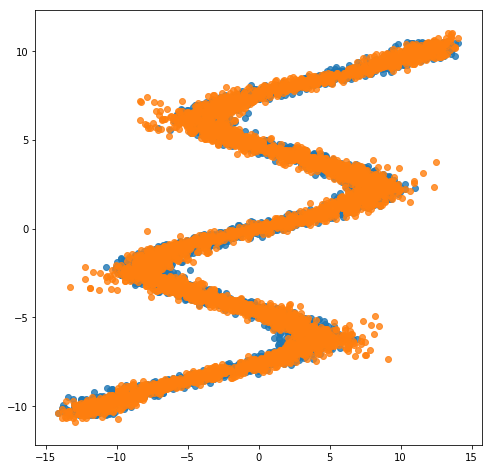

In [8]:
X_test, y_test = build_toy_dataset(N)
y_pred = m.posterior_predictive(["y"], data = {"x": X_test}).sample()

plt.figure(figsize=(8, 8))
sns.regplot(X_test, y_test, fit_reg=False)
sns.regplot(X_test, y_pred, fit_reg=False)
plt.show()

## Acknowledgments

This tutorial is inspired by [David Ha's blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) and [Edward's tutorial](http://edwardlib.org/tutorials/mixture-density-network).